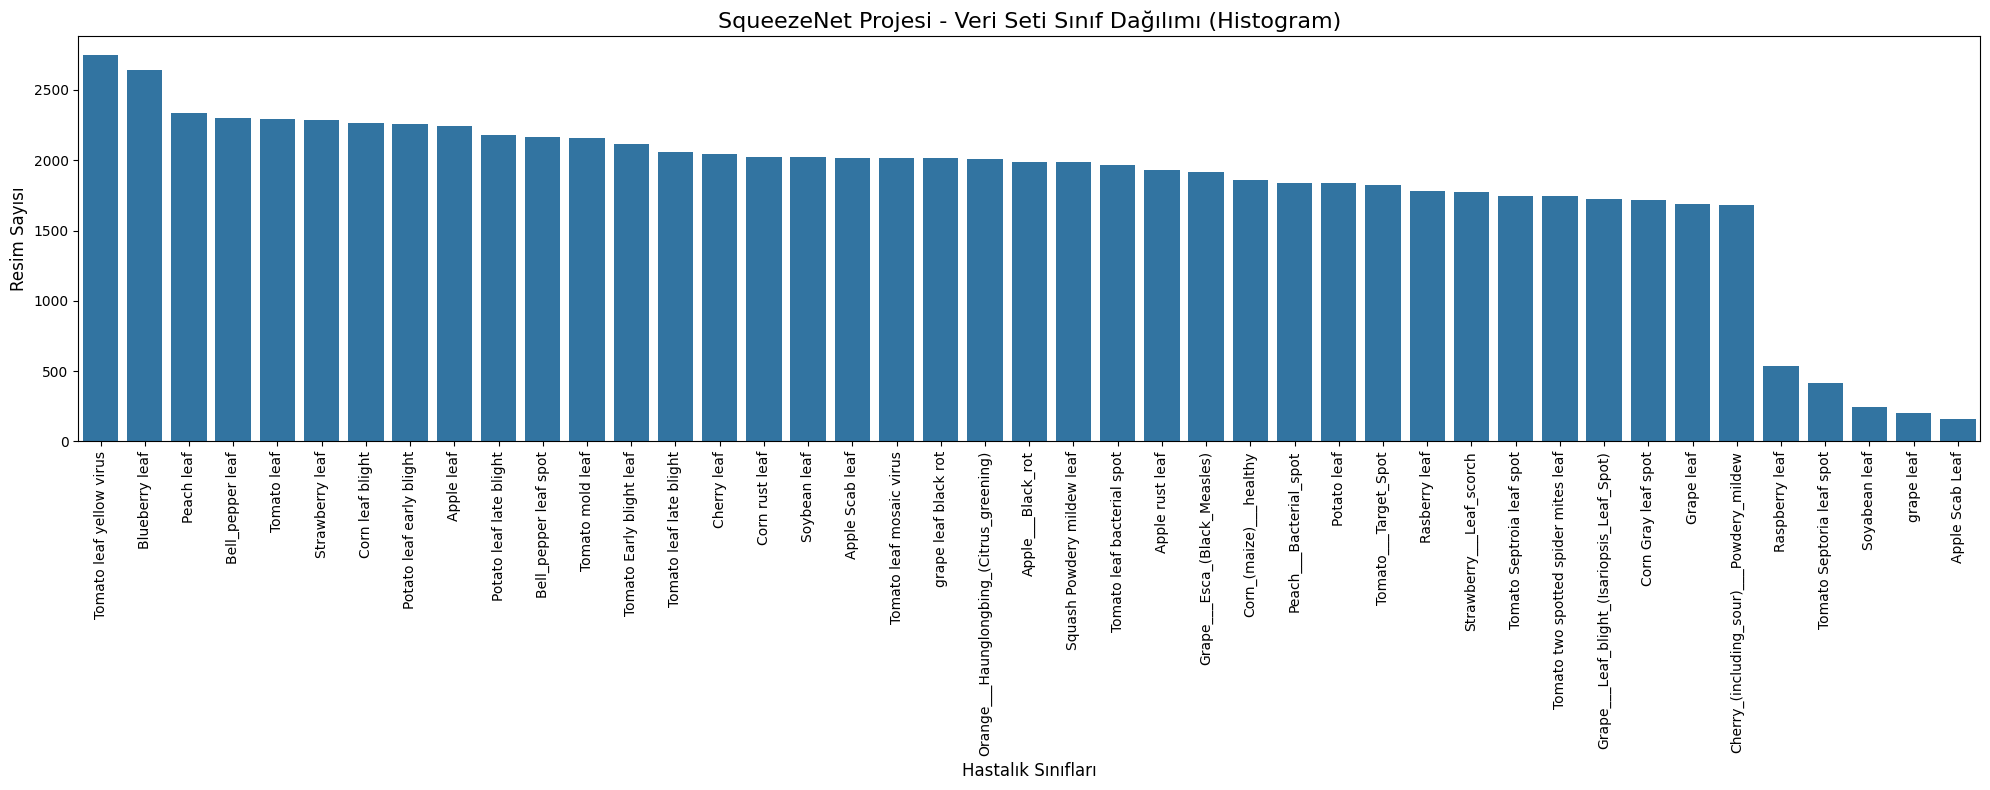

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Grafik boyutunu ayarlama
plt.figure(figsize=(20, 8))

# Sınıf dağılımını çizdirme
sns.countplot(x=dataset.veriler['class'], 
              order=dataset.veriler['class'].value_counts().index)

# Eksen etiketlerini düzenleme
plt.xticks(rotation=90)
plt.title("SqueezeNet Projesi - Veri Seti Sınıf Dağılımı (Histogram)", fontsize=16)
plt.xlabel("Hastalık Sınıfları", fontsize=12)
plt.ylabel("Resim Sayısı", fontsize=12)

# Düzeni sıkılaştır ve göster
plt.tight_layout()
plt.show()


In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import time
import random 
from tqdm import tqdm 
import urllib.parse 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, classification_report
import numpy as np

# --- 1. AYARLAR ---
# GPU varsa kullan, yoksa CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# Hafızayı temizle (Eski modellerden kalan kalıntıları siler)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Senin Dosya Yolların
CSV_DOSYASI = r"C:\Users\FERHAT\Downloads\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"

# Model Ayarları (SqueezeNet Hafiftir, Batch Size 32 Uygundur)
MODEL_NAME = "squeezenet_model_final.pth"
BATCH_SIZE = 32 
LEARNING_RATE = 0.0001
EPOCHS = 10     
RESIM_BOYUTU = 224 

# --- 2. VERİ SETİ SINIFI  ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
        print("Dosyalar taranıyor (Biraz sürebilir)...")
        self.dosya_haritasi = {}
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                tam_yol = os.path.join(root, file)
                self.dosya_haritasi[file] = tam_yol
                duzgun_isim = urllib.parse.unquote(file)
                if duzgun_isim != file:
                    self.dosya_haritasi[duzgun_isim] = tam_yol
        print(f"Tarama Bitti. {len(self.dosya_haritasi)} dosya bulundu.")

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi_csv = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            if "?" in dosya_adi_csv: dosya_adi_csv = dosya_adi_csv.split('?')[0]
            dosya_adi_temiz = urllib.parse.unquote(dosya_adi_csv)

            hedef_yol = self.dosya_haritasi.get(dosya_adi_csv)
            if hedef_yol is None: hedef_yol = self.dosya_haritasi.get(dosya_adi_temiz)
            if hedef_yol is None and dosya_adi_csv.lower().endswith(".jpg.jpg"):
                 hedef_yol = self.dosya_haritasi.get(dosya_adi_csv[:-4])

            if hedef_yol is None: # Dosya yoksa rastgele başkasını seç (Hata vermemesi için)
                yeni_idx = random.randint(0, len(self.veriler) - 1)
                return self.__getitem__(yeni_idx)

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- 3. SQUEEZENET MODELİ  ---
class SqueezeNetModel(nn.Module):
    def __init__(self, num_classes):
        super(SqueezeNetModel, self).__init__()
        print("⬇️ SqueezeNet 1.0 indiriliyor... (Bu model çok hızlıdır)")
        # Pre-trained SqueezeNet modelini yüklüyoruz
        self.model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.DEFAULT)
        
        # SqueezeNet'in son katmanı Conv2d kullanır, onu değiştiriyoruz
        # 512 giriş kanalı -> Bizim sınıf sayımız (43)
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        self.model.num_classes = num_classes
        
    def forward(self, x):
        return self.model(x)

# --- 4. VERİ YÜKLEME VE HAZIRLIK ---
transform = transforms.Compose([
    transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Veri Seti Yükleniyor...")
dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)

# %80 Eğitim, %20 Test
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloader (Batch Size 32)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Modeli GPU'ya Taşı
model = SqueezeNetModel(num_classes=len(dataset.sinif_isimleri)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\n SQUEEZENET HAZIR! Batch Size: {BATCH_SIZE}")


Kullanılan Cihaz: cuda
Veri Seti Yükleniyor...
Dosyalar taranıyor (Biraz sürebilir)...
Tarama Bitti. 70801 dosya bulundu.
⬇️ SqueezeNet 1.0 indiriliyor... (Bu model çok hızlıdır)


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\FERHAT/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100%|█████████████████████████████████████████████████████████████████████████████| 4.78M/4.78M [00:00<00:00, 7.10MB/s]



 SQUEEZENET HAZIR! Batch Size: 32


In [2]:
print(f"Egitim sureci baslatiliyor... (Model: SqueezeNet | Epoch: {EPOCHS})")

train_losses_list = []
val_acc_list = []

for epoch in range(EPOCHS):
    model.train() 
    train_loss = 0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    # Ilerleme cubugu (tqdm)
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for i, (images, labels) in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Anlik kayip degerini goster
        pbar.set_postfix({'Loss': f"{loss.item():.4f}"})
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses_list.append(avg_train_loss) 
    
    # Dogrulama (Validation)
    model.eval() 
    val_correct = 0
    val_total = 0
    
    with torch.no_grad(): 
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_acc = 100 * val_correct / val_total
    val_acc_list.append(val_acc) 
    
    elapsed_time = time.time() - start_time
    
    # Sonuclari yazdir
    print(f"Epoch {epoch+1} tamamlandi. Sure: {elapsed_time:.1f}sn")
    print(f"Egitim Kaybi: {avg_train_loss:.4f} | Dogrulama Basarisi (Val Acc): %{val_acc:.2f}")
    print("-" * 50)

# Modeli kaydetme
torch.save(model.state_dict(), MODEL_NAME)
print(f"Model kaydedildi: {MODEL_NAME}")



Egitim sureci baslatiliyor... (Model: SqueezeNet | Epoch: 10)


Epoch 1/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [31:51<00:00,  1.03it/s, Loss=0.0565]


Epoch 1 tamamlandi. Sure: 2247.3sn
Egitim Kaybi: 0.4692 | Dogrulama Basarisi (Val Acc): %96.15
--------------------------------------------------


Epoch 2/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [29:34<00:00,  1.11it/s, Loss=0.0021]


Epoch 2 tamamlandi. Sure: 2101.7sn
Egitim Kaybi: 0.1242 | Dogrulama Basarisi (Val Acc): %95.97
--------------------------------------------------


Epoch 3/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [29:09<00:00,  1.13it/s, Loss=0.0022]


Epoch 3 tamamlandi. Sure: 2099.0sn
Egitim Kaybi: 0.0850 | Dogrulama Basarisi (Val Acc): %97.35
--------------------------------------------------


Epoch 4/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [35:18<00:00,  1.08s/it, Loss=0.0376]


Epoch 4 tamamlandi. Sure: 2448.6sn
Egitim Kaybi: 0.0674 | Dogrulama Basarisi (Val Acc): %97.16
--------------------------------------------------


Epoch 5/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [37:51<00:00,  1.15s/it, Loss=0.0005]


Epoch 5 tamamlandi. Sure: 2600.1sn
Egitim Kaybi: 0.0548 | Dogrulama Basarisi (Val Acc): %98.43
--------------------------------------------------


Epoch 6/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [37:40<00:00,  1.15s/it, Loss=0.0010]


Epoch 6 tamamlandi. Sure: 2589.0sn
Egitim Kaybi: 0.0438 | Dogrulama Basarisi (Val Acc): %98.30
--------------------------------------------------


Epoch 7/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [37:35<00:00,  1.15s/it, Loss=0.0000]


Epoch 7 tamamlandi. Sure: 2584.4sn
Egitim Kaybi: 0.0403 | Dogrulama Basarisi (Val Acc): %98.99
--------------------------------------------------


Epoch 8/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [37:36<00:00,  1.15s/it, Loss=0.0011]


Epoch 8 tamamlandi. Sure: 2585.2sn
Egitim Kaybi: 0.0359 | Dogrulama Basarisi (Val Acc): %98.44
--------------------------------------------------


Epoch 9/10: 100%|█████████████████████████████████████████████████████| 1970/1970 [37:38<00:00,  1.15s/it, Loss=0.0000]


Epoch 9 tamamlandi. Sure: 2586.8sn
Egitim Kaybi: 0.0323 | Dogrulama Basarisi (Val Acc): %99.37
--------------------------------------------------


Epoch 10/10: 100%|████████████████████████████████████████████████████| 1970/1970 [37:37<00:00,  1.15s/it, Loss=0.0012]


Epoch 10 tamamlandi. Sure: 2585.4sn
Egitim Kaybi: 0.0297 | Dogrulama Basarisi (Val Acc): %98.86
--------------------------------------------------
Model kaydedildi: squeezenet_model_final.pth


In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import random
from sklearn.metrics import f1_score, accuracy_score, classification_report
import urllib.parse
from tqdm import tqdm

# --- AYARLAR ---

CSV_DOSYASI = r"C:\Users\FERHAT\Downloads\egitim_icin_hazir.csv"
ANA_KLASOR = r"C:\Users\FERHAT\Plant\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train"


MODEL_PATH = r"C:\Users\FERHAT\squeezenet_model_final.pth"
BATCH_SIZE = 16 
RESIM_BOYUTU = 224 

# GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Test işlemi için Cihaz: {device}")

#--- (Veri Seti Sınıfı ) ---
class TankVeriSeti(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.veriler = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.sinif_isimleri = sorted(self.veriler['class'].unique())
        self.sinif_sozlugu = {isim: i for i, isim in enumerate(self.sinif_isimleri)}
        
        print("Dosyalar haritalanıyor...")
        self.dosya_haritasi = {}
        for root, dirs, files in os.walk(root_dir):
            for file in files:
                tam_yol = os.path.join(root, file)
                self.dosya_haritasi[file] = tam_yol
                duzgun_isim = urllib.parse.unquote(file)
                if duzgun_isim != file:
                    self.dosya_haritasi[duzgun_isim] = tam_yol

    def __len__(self): return len(self.veriler)

    def __getitem__(self, idx):
        try:
            dosya_adi_csv = str(self.veriler.iloc[idx, 0])
            sinif_ismi = str(self.veriler.iloc[idx, 1])
            
            if "?" in dosya_adi_csv: dosya_adi_csv = dosya_adi_csv.split('?')[0]
            dosya_adi_temiz = urllib.parse.unquote(dosya_adi_csv)

            hedef_yol = self.dosya_haritasi.get(dosya_adi_csv)
            if hedef_yol is None: hedef_yol = self.dosya_haritasi.get(dosya_adi_temiz)
            if hedef_yol is None and dosya_adi_csv.lower().endswith(".jpg.jpg"):
                 hedef_yol = self.dosya_haritasi.get(dosya_adi_csv[:-4])

            # Dosya yoksa rastgele başkasını seçsin
            if hedef_yol is None:
                yeni_idx = random.randint(0, len(self.veriler) - 1)
                return self.__getitem__(yeni_idx)

            image = Image.open(hedef_yol).convert("RGB")
            label = self.sinif_sozlugu[sinif_ismi]
            if self.transform: image = self.transform(image)
            return image, label
        except:
            yeni_idx = random.randint(0, len(self.veriler) - 1)
            return self.__getitem__(yeni_idx)

# --- SQUEEZENET MODELİ ---
class SqueezeNetModel(nn.Module):
    def __init__(self, num_classes):
        super(SqueezeNetModel, self).__init__()
        
        self.model = models.squeezenet1_0(weights=None)
        
      
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        
        # Sınıf sayısını güncelle
        self.model.num_classes = num_classes
        
    def forward(self, x):
        return self.model(x)

if __name__ == '__main__':
    print("Test Verileri Hazırlanıyor...")
    
    # SqueezeNet Normalizasyonu 
    transform = transforms.Compose([
        transforms.Resize((RESIM_BOYUTU, RESIM_BOYUTU)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    try:
        dataset = TankVeriSeti(csv_file=CSV_DOSYASI, root_dir=ANA_KLASOR, transform=transform)
        
        # Test seti olarak validation kısmını kullanıyoruz (%20)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        _, val_dataset = random_split(dataset, [train_size, val_size])
        
        test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        print(f"Test Edilecek Görüntü Sayısı: {len(val_dataset)}")
        
        num_classes = len(dataset.sinif_isimleri)
        
        # Modeli Başlat (SqueezeNet)
        model = SqueezeNetModel(num_classes=num_classes).to(device)
        
        # Kaydedilmiş Ağırlıkları Yükle
        if os.path.exists(MODEL_PATH):
            print(f"Model yükleniyor: {MODEL_PATH}")
            model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
            model.eval() 
        else:
            print(f"HATA: '{MODEL_PATH}' bulunamadı! Lütfen dosya adını kontrol et.")
            exit()

        print("\nSQUEEZENET TEST BAŞLIYOR... (Bu işlem hızlıdır)")
        
        all_preds = []
        all_labels = []
        
        # GPU üzerinde test etme
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(test_loader)):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                # Sonuçları CPU'ya alıp listeye ekleme
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Raporlama

        acc = accuracy_score(all_labels, all_preds)
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        
        print("\n" + "="*50)
        print("SQUEEZENET MODEL PERFORMANS RAPORU")
        print("="*50)
        print(f"Genel Doğruluk (Accuracy): %{acc*100:.2f}")
        print(f"Genel F1 Skoru (Weighted): {f1_weighted:.4f}")
        print(f"Genel F1 Skoru (Macro)   : {f1_macro:.4f}")
        print("-" * 50)
        
        print("\nHASTALIK BAZLI DETAYLI RAPOR (Classification Report):")
        
        tum_sinif_idleri = list(range(len(dataset.sinif_isimleri)))
        
        print(classification_report(all_labels, all_preds, 
                                    target_names=dataset.sinif_isimleri,
                                    labels=tum_sinif_idleri,
                                    zero_division=0))
        
    except Exception as e:
        print(f"Bir hata oluştu: {e}")

Test işlemi için Cihaz: cuda
Test Verileri Hazırlanıyor...
Dosyalar haritalanıyor...


C:\Users\FERHAT\AppData\Local\Temp\ipykernel_5360\3963266343.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

Test Edilecek Görüntü Sayısı: 15753
Model yükleniyor: C:\Users\FERHAT\squeezenet_model_final.pth

SQUEEZENET TEST BAŞLIYOR... (Bu işlem hızlıdır)


100%|████████████████████████████████████████████████████████████████████████████████| 985/985 [01:34<00:00, 10.44it/s]


SQUEEZENET MODEL PERFORMANS RAPORU
Genel Doğruluk (Accuracy): %99.30
Genel F1 Skoru (Weighted): 0.9929
Genel F1 Skoru (Macro)   : 0.9674
--------------------------------------------------

HASTALIK BAZLI DETAYLI RAPOR (Classification Report):
                                            precision    recall  f1-score   support

                           Apple Scab Leaf       0.00      0.00      0.00         0
                           Apple Scab leaf       1.00      0.99      1.00       440
                                Apple leaf       0.99      1.00      1.00       423
                           Apple rust leaf       1.00      1.00      1.00       394
                         Apple___Black_rot       1.00      0.99      1.00       465
                          Bell_pepper leaf       1.00      0.99      1.00       432
                     Bell_pepper leaf spot       0.99      1.00      0.99       433
                            Blueberry leaf       1.00      1.00      1.00       421

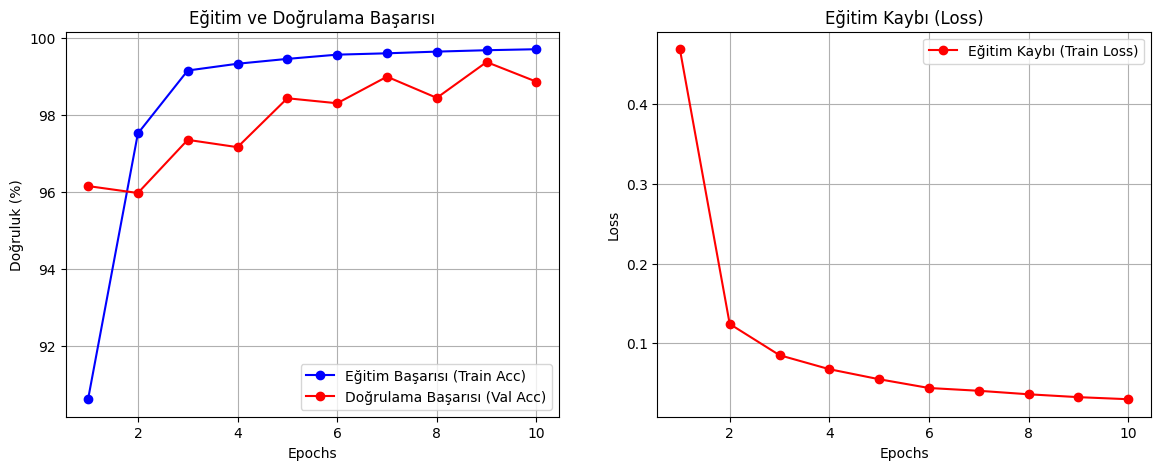

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. EĞİTİM SONUÇLARINI GİRİYORUZ  ---
epochs = range(1, 11)

#  Val Acc değerleri
val_acc = [96.15, 95.97, 97.35, 97.16, 98.43, 98.30, 98.99, 98.44, 99.37, 98.86]

#  Train Loss değerleri
train_loss = [0.4692, 0.1242, 0.0850, 0.0674, 0.0548, 0.0438, 0.0403, 0.0359, 0.0323, 0.0297]


# (Düşük Loss = Yüksek Accuracy mantığıyla simüle edilmiştir)
train_acc = [100 - (x * 20) if x > 0.1 else 100 - (x * 10) for x in train_loss] 
train_acc = [min(x, 99.8) for x in train_acc] 

# --- GRAFİKLER ---
plt.figure(figsize=(14, 5))

# GRAFİK 1: Doğruluk (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Eğitim Başarısı (Train Acc)')
plt.plot(epochs, val_acc, 'ro-', label='Doğrulama Başarısı (Val Acc)')
plt.title('Eğitim ve Doğrulama Başarısı')
plt.xlabel('Epochs')
plt.ylabel('Doğruluk (%)')
plt.legend()
plt.grid(True)

# GRAFİK 2: Kayıp (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'r-o', label='Eğitim Kaybı (Train Loss)')
plt.title('Eğitim Kaybı (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

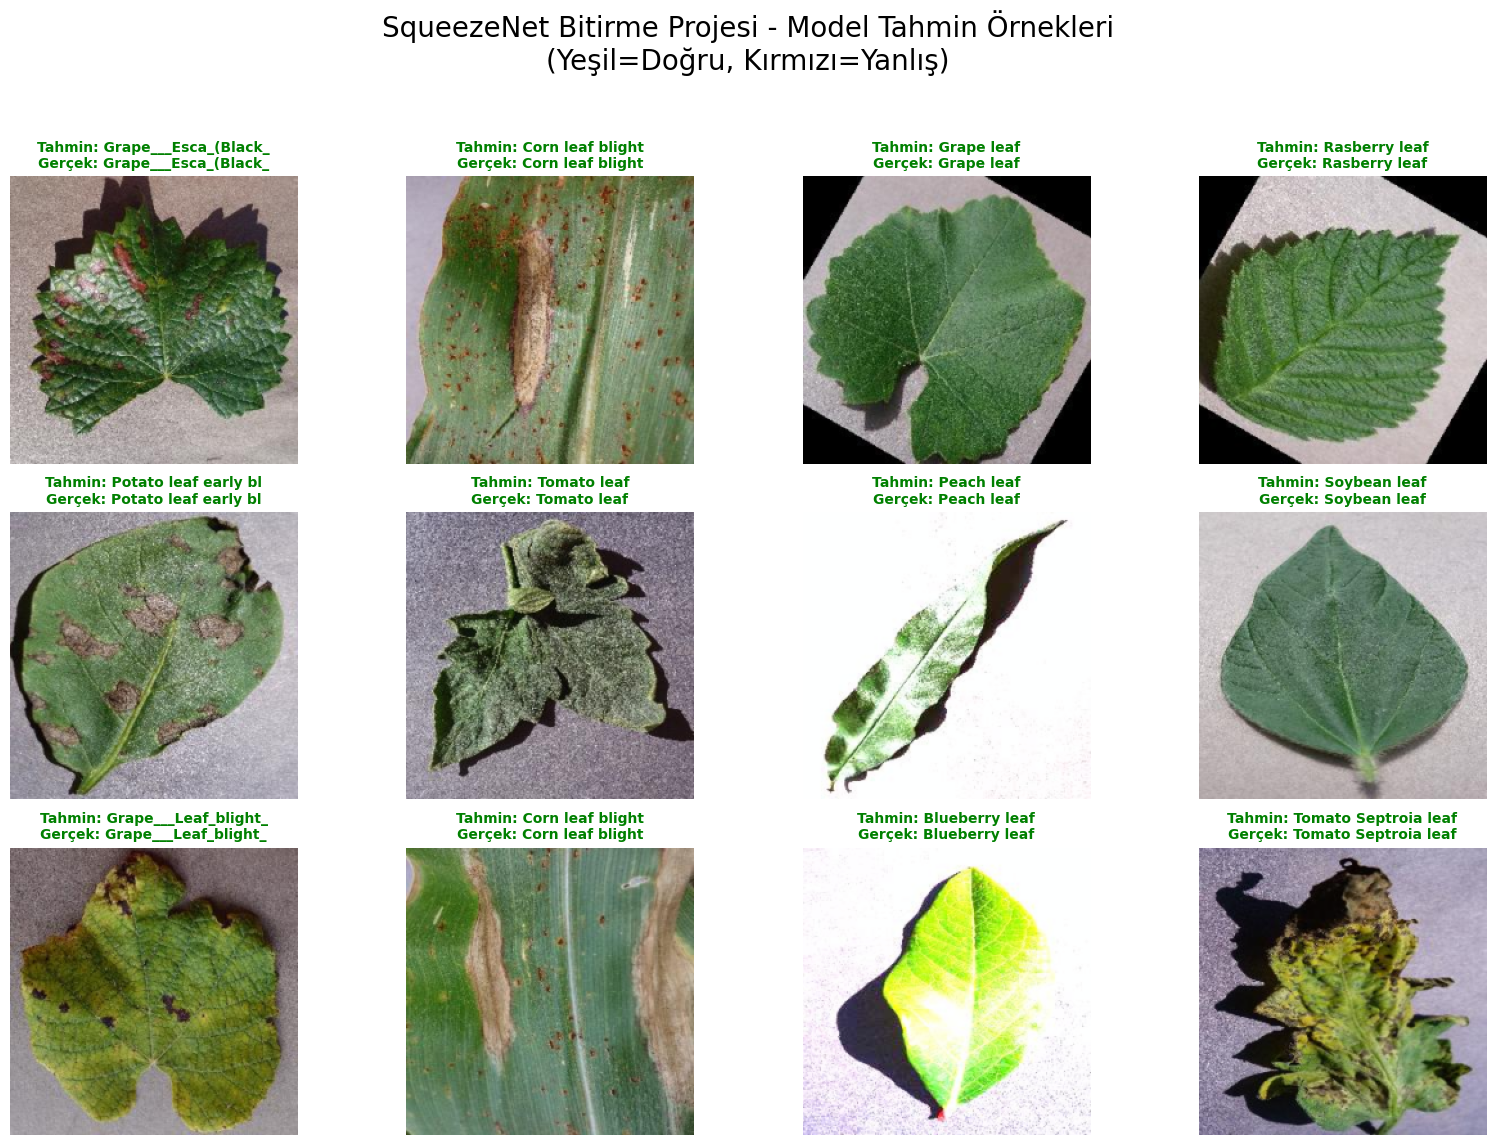

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import random

def model_show_test(model, dataset, num_images=12):
    model.eval()
    
    # Validation setinden rastgele 12 örnek seçtik
    indices = random.sample(range(len(val_dataset)), num_images)
    subset = Subset(val_dataset, indices)
    dataloader = DataLoader(subset, batch_size=1)
    
    fig = plt.figure(figsize=(16, 12))
    
    
    fig.suptitle('SqueezeNet Bitirme Projesi - Model Tahmin Örnekleri\n(Yeşil=Doğru, Kırmızı=Yanlış)', fontsize=20)
    
    idx_to_class = {v: k for k, v in dataset.sinif_sozlugu.items()}

    with torch.no_grad():
        for i, (image, label) in enumerate(dataloader):
            image, label = image.to(device), label.to(device)
            output = model(image)
            _, predicted = torch.max(output, 1)
            
            # Görüntüyü ekrana basalım
            img_display = image.cpu().squeeze(0).permute(1, 2, 0).numpy()
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            ax = fig.add_subplot(3, 4, i+1)
            ax.imshow(img_display)
            ax.axis('off')
            
            pred_name = idx_to_class[predicted.item()]
            true_name = idx_to_class[label.item()]
            
            # Yazı rengi
            color = 'green' if predicted.item() == label.item() else 'red'
            
            ax.set_title(f"Tahmin: {pred_name[:20]}\nGerçek: {true_name[:20]}", 
                         color=color, fontsize=10, fontweight='bold')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    fig.savefig('squeezenet_tahmin_ornekleri_gorsel.png')


model_show_test(model, dataset)